### Билиотеки

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
from scipy.stats import zscore


# Статистические модели
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Машинное обучение
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression, RFE, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor

# Работа с календарем
from workalendar.europe import Russia

### Чтение и первичный просмотр

In [30]:
df = pd.read_excel("data.xlsx", parse_dates=['Date'])
df['Day_of_week'] = df['Date'].dt.dayofweek # 0 - пнд ... 6 - вс
df.head()

,Date,Income,Outcome,Balance,Day_of_week
0,2017-01-09,1.343028,1.487865,-0.155904,0
1,2017-01-10,1.068610,1.194182,-0.125572,1
2,2017-01-11,0.944429,0.936663,0.007767,2
3,2017-01-12,1.672202,0.875379,0.800391,3
4,2017-01-13,0.955924,0.975645,-0.019721,4


In [31]:
# маски
full_zero_mask = (df['Income'] == 0) & (df['Outcome'] == 0) & (df['Balance'] == 0)
weekend_mask = (df['Day_of_week'] == 5) | (df['Day_of_week'] == 6)

full_zero_indices = df[full_zero_mask].index.tolist() # три нуля
weekend_zero_indices = df[full_zero_mask & weekend_mask].index.tolist() # выходные нули
weekday_zero_indices = df[full_zero_mask & ~weekend_mask].index.tolist() # будние нули

print(f"Всего полных нулей (Income=Outcome=Balance=0): {len(full_zero_indices)}")
print(f"Из них в выходные дни: {len(weekend_zero_indices)}")
print(f"Из них в будние дни: {len(weekday_zero_indices)}")

min_year = df['Date'].dt.year.min()
max_year = df['Date'].dt.year.max()
cal = Russia()
all_holidays = []

for year in range(min_year, max_year + 1):
    all_holidays.extend(cal.holidays(year))

# df с праздниками
holidays_df = pd.DataFrame(all_holidays, columns=['date', 'holiday_name'])
holidays_df['date'] = pd.to_datetime(holidays_df['date'])


weekday_zero_dates = df.loc[weekday_zero_indices, 'Date']  

# добавим признак праздника в основном DataFrame
df['is_holiday'] = df['Date'].isin(holidays_df['date']).astype(int)

# проверяем пересечения с нулевыми буднями
holiday_zeros = weekday_zero_dates[weekday_zero_dates.isin(holidays_df['date'])]
print(f"Из {len(weekday_zero_dates)} нулевых будней:")
print(f"- Совпадает с праздниками: {len(holiday_zeros)}")

holiday_mask = df['Date'].isin(holidays_df['date'])

# Находим аномальные нули (не выходные и не праздники)
anomalous_zeros_mask = full_zero_mask & ~weekend_mask & ~holiday_mask
anomalous_zeros = df[anomalous_zeros_mask]
print(f"Найдено {len(anomalous_zeros)} подозрительных нулевых строк:")
print(anomalous_zeros)


Всего полных нулей (Income=Outcome=Balance=0): 431
Из них в выходные дни: 394
Из них в будние дни: 37
Из 37 нулевых будней:
- Совпадает с праздниками: 30
Найдено 7 подозрительных нулевых строк:
           Date  Income  Outcome  Balance  Day_of_week  is_holiday
119  2017-05-08     0.0      0.0      0.0            0           0
305  2017-11-10     0.0      0.0      0.0            4           0
639  2018-10-10     0.0      0.0      0.0            2           0
843  2019-05-02     0.0      0.0      0.0            3           0
844  2019-05-03     0.0      0.0      0.0            4           0
851  2019-05-10     0.0      0.0      0.0            4           0
1262 2020-06-24     0.0      0.0      0.0            2           0


In [32]:
anomalous_indices = df[anomalous_zeros_mask].index
df.loc[anomalous_indices, 'is_holiday'] = 1

Понимаем, что 2017-05-08, 2019-05-02, 2019-05-03, 2019-05-10 - это переносы майских праздников.
Остальные два и это тоже перенесённые выходные и один технический день 2018-10-10. 
В общем, определим их все как выходные, тем самым создав новую фичу "is_holiday"

### Добавим макроэкономиеские факторы: курс доллара, инфляция, ключевая ставка (данные взяты с сайта https://www.cbr.ru)

In [33]:
##############################################
# USD_RUB
df_usd = pd.read_excel("usd.xlsx",  parse_dates=['data'])

df = df.merge(
    df_usd[['data', 'curs']],
    left_on='Date',
    right_on='data',
    how='left'
)

df = df.drop(columns=['data'])
df = df.rename(columns={'curs': 'USD_RUB'})
df['USD_RUB'] = df['USD_RUB'].bfill()  # первым известным значением

###########################################
# INFLATION
inflation_df = pd.read_excel("inflation.xlsx", parse_dates=['Дата'])
inflation_df['Дата'] = '01.' + inflation_df['Дата']  # Добавляем первое число
inflation_df['Дата'] = pd.to_datetime(inflation_df['Дата'], format='%d.%m.%Y')  # Преобразуем в дату

df = df.merge(
    inflation_df[['Дата', 'Ключевая ставка, % годовых', 'Инфляция, % г/г']],
    left_on='Date',
    right_on='Дата',
    how='left'
)

df = df.drop(columns=['Дата'])
df = df.rename(columns={'Ключевая ставка, % годовых': 'Key_rate', 'Инфляция, % г/г': 'Inflation'})
df['Key_rate'] = df['Key_rate'].bfill().ffill()
df['Inflation'] = df['Inflation'].bfill().ffill()

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_8172\1821521842.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  inflation_df = pd.read_excel("inflation.xlsx", parse_dates=['Дата'])


### Пометим выбросы больше 3-х сигм

In [ ]:
##############################################
# Обработка выбросов
from scipy.stats import zscore


df['is_outlier'] = 0  # По умолчанию не выброс
z_scores = zscore(df['Balance'])
df.loc[np.abs(z_scores) >= 3, 'is_outlier'] = 1  # Помечаем выбросы

print("Количество выбросов:", df['is_outlier'].sum())
print("Общее количество строк:", len(df))

Количество выбросов: 33
Общее количество строк: 1543


### Сконструируем из таргета фичи

In [35]:
# добавляем фичи руками 
def add_features(df, target='Balance'):
    """Создание временных признаков""" #кол-во лагов можно менять надо подумать
    df = df.copy()
    for lag in [1, 7, 30]:
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)

    for window in [1, 7, 30]:
        df[f'{target}_rolling_mean_{window}'] = df[target].rolling(window).mean().shift(1)
        df[f'{target}_rolling_std_{window}'] = df[target].rolling(window).std().shift(1)

    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['quarter'] = df['Date'].dt.quarter
    df['year'] = df['Date'].dt.year
    df['day_of_year'] = df['Date'].dt.dayofyear
    return df.fillna(0)

### Разделим нашу выборку 

Возьмём прогноз на 30 дней

In [36]:
##############################################

total_days = len(df)  
forecast_horizon = 30  # Прогноз на n дней вперёд
train_size = total_days - forecast_horizon  # Размер обучающей выборки

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]   

# test_size = int(len(df) * 0.15)
# df_train, df_test = df.iloc[:-test_size], df.iloc[-test_size:]


df_train = add_features(df_train)
df_test = add_features(df_test)

# outcome надо выкидывать так как если они остануться вместе с Income это утечка данных
X_train, X_test = df_train.drop(columns=['Balance', 'Date', 'Outcome']), df_test.drop(columns=['Balance', 'Date','Outcome'])
y_train, y_test = df_train['Balance'], df_test['Balance']

X_train

,Income,Day_of_week,is_holiday,USD_RUB,Key_rate,Inflation,is_outlier,Balance_lag_1,Balance_lag_7,Balance_lag_30,...,Balance_rolling_std_1,Balance_rolling_mean_7,Balance_rolling_std_7,Balance_rolling_mean_30,Balance_rolling_std_30,day_of_week,month,quarter,year,day_of_year
0,1.343028,0,0,59.8961,10.0,4.6,0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0,1,1,2017,9
1,1.068610,1,0,59.8961,10.0,4.6,0,-0.155904,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,1,1,1,2017,10
2,0.944429,2,0,59.9533,10.0,4.6,0,-0.125572,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,2,1,1,2017,11
3,1.672202,3,0,60.1614,10.0,4.6,0,0.007767,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,3,1,1,2017,12
4,0.955924,4,0,59.4978,10.0,4.6,0,0.800391,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,4,1,1,2017,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,2.580721,3,0,73.7532,4.5,5.8,0,-0.873672,-0.472309,-0.376769,...,0.0,-0.301426,0.331568,-0.227531,0.271765,3,2,1,2021,56
1509,2.620222,4,0,73.4747,4.5,5.8,0,-0.529504,-0.488233,-0.170353,...,0.0,-0.309597,0.337139,-0.232622,0.276054,4,2,1,2021,57
1510,0.000000,5,0,74.4373,4.5,5.8,0,-0.355811,-0.266053,0.277592,...,0.0,-0.290680,0.329063,-0.238804,0.276687,5,2,1,2021,58
1511,0.000000,6,0,74.0448,4.5,5.8,0,0.000000,0.000000,-0.401324,...,0.0,-0.252672,0.347244,-0.248057,0.263132,6,2,1,2021,59


### Feature selection

In [ ]:
def smart_feature_selection(
    X_train, 
    y_train,
    mi_threshold=0.05,      # Порог для Mutual Information
    corr_threshold=0.85,    # Порог для корреляции
    n_features_to_select=15 # Для RFE
):
    """
    Комплексный отбор признаков:
    1. Mutual Information (фильтрационный) + корреляция.
    2. LassoCV (встроенный).
    3. RFE с XGBoost (оберточный, учитывает нелинейности).
    4. Сравнение результатов всех методов.
    
    Возвращает признаки, выбранные хотя бы двумя методами.
    """
    # 1. Фильтрационные методы
    # 1.1. Mutual Information
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    mi_selected = X_train.columns[mi_scores > mi_threshold]
    X_filtered = X_train[mi_selected]
    
    # 1.2. Удаление коррелированных признаков
    corr_matrix = X_filtered.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
    X_filtered = X_filtered.drop(columns=to_drop)
    
    print(f"[Фильтрационные] Отобрано {len(mi_selected)} признаков по MI, осталось {X_filtered.shape[1]} после корреляции.")

    # 2. Встроенные методы
    # 2.1. LassoCV
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_filtered, y_train)
    lasso_selected = X_filtered.columns[lasso.coef_ != 0]
    
    # 2.2. Вариант с RandomForest (нелинейная зависимость)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_filtered, y_train)
    rf_importances = pd.Series(rf.feature_importances_, index=X_filtered.columns)
    rf_selected = rf_importances[rf_importances > rf_importances.quantile(0.75)].index
    
    print(f"[Встроенные] Lasso выбрал {len(lasso_selected)}, RandomForest — {len(rf_selected)} признаков.")

    # 3. Оберточные методы
    # 3.1. RFE с XGBoost (нелинейность)
    xgb = XGBRegressor(random_state=42)
    rfe = RFE(estimator=xgb, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_filtered, y_train)
    rfe_selected = X_filtered.columns[rfe.support_]
    
    print(f"[Оберточные] RFE выбрал {len(rfe_selected)} признаков.")

    # 4. Сравнение методов
    all_methods = {
        "MI": set(mi_selected),
        "Lasso": set(lasso_selected),
        "RandomForest": set(rf_selected),
        "RFE": set(rfe_selected)
    }
    
    # Признаки, выбранные хотя бы двумя методами
    feature_votes = Counter()
    for method, features in all_methods.items():
        feature_votes.update(features)
    
    final_features = [feat for feat, cnt in feature_votes.items() if cnt >= 2]
    
    print("\nИтоговые признаки (выбраны ≥2 методами):", final_features)
    return final_features

In [38]:
ff_all = smart_feature_selection(X_train, y_train)

[Фильтрационные] Отобрано 10 признаков по MI, осталось 8 после корреляции.
[Встроенные] Lasso выбрал 7, RandomForest — 2 признаков.
[Оберточные] RFE выбрал 8 признаков.

Итоговые признаки (выбраны ≥2 методами): ['Balance_lag_7', 'Day_of_week', 'year', 'day_of_year', 'is_outlier', 'Balance_lag_1', 'Balance_lag_30', 'Income']


C:\Users\Кирилл\AppData\Roaming\Python\Python311\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=15 > n_features=8. There will be no feature selection and all features will be kept.
  warnings.warn(


In [39]:
# Загрузка и подготовка данных
X_train= X_train[ff_all]  # Используем предварительно отобранные фичи
X_test= X_test[ff_all]

### Посмотрим на ARIMA, SARIMA, SARIMAX

In [40]:
# Проверка стационарности
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')

# Подготовка временных рядов
y_train_series = pd.Series(y_train.values, index=X_train.index)
y_test_series = pd.Series(y_test.values, index=X_test.index)

print("Проверка стационарности исходного ряда:")
check_stationarity(y_train_series)

# 1. Простая ARIMA модель
arima_model = ARIMA(y_train_series, order=(1,1,1))
arima_results = arima_model.fit()
arima_pred = arima_results.get_forecast(steps=len(y_test_series)).predicted_mean

# 2. SARIMA модель (с сезонностью)
sarima_model = SARIMAX(y_train_series, 
                      order=(1,1,1), 
                      seasonal_order=(1,1,1,7))
sarima_results = sarima_model.fit()
sarima_pred = sarima_results.get_forecast(steps=len(y_test_series)).predicted_mean

# 3. SARIMAX модель (с экзогенными переменными)
# Используем отобранные признаки как экзогенные переменные
sarimax_model = SARIMAX(y_train_series,
                       exog=X_train,
                       order=(1,1,1),
                       seasonal_order=(1,1,1,7))
sarimax_results = sarimax_model.fit()
sarimax_pred = sarimax_results.get_forecast(steps=len(y_test_series), exog=X_test).predicted_mean

# Вычисление метрик
def calculate_metrics(true, pred, model_name):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    # print(f"\nМетрики для {model_name}:")
    # print(f"MAE: {mae:.3f}")
    # print(f"RMSE: {rmse:.3f}")
    # print(f"R²: {r2:.3f}")
    return mae, rmse, r2

# Сравнение метрик
metrics = {}
metrics['ARIMA'] = calculate_metrics(y_test_series, arima_pred, 'ARIMA(1,1,1)')
metrics['SARIMA'] = calculate_metrics(y_test_series, sarima_pred, 'SARIMA(1,1,1)(1,1,1,7)')
metrics['SARIMAX'] = calculate_metrics(y_test_series, sarimax_pred, 'SARIMAX(1,1,1)')

# Сводная таблица метрик
metrics_df = pd.DataFrame(metrics, index=['MAE', 'RMSE', 'R2']).T
print("\nСводная таблица метрик:")
print(metrics_df)

Проверка стационарности исходного ряда:
ADF Statistic: -4.926
p-value: 0.000
Critical Values:
   1%: -3.435
   5%: -2.863
   10%: -2.568

Сводная таблица метрик:
              MAE      RMSE        R2
ARIMA    0.370336  0.549965 -0.061785
SARIMA   0.329190  0.522976  0.039869
SARIMAX  0.253042  0.432705  0.342720


C:\Users\Кирилл\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


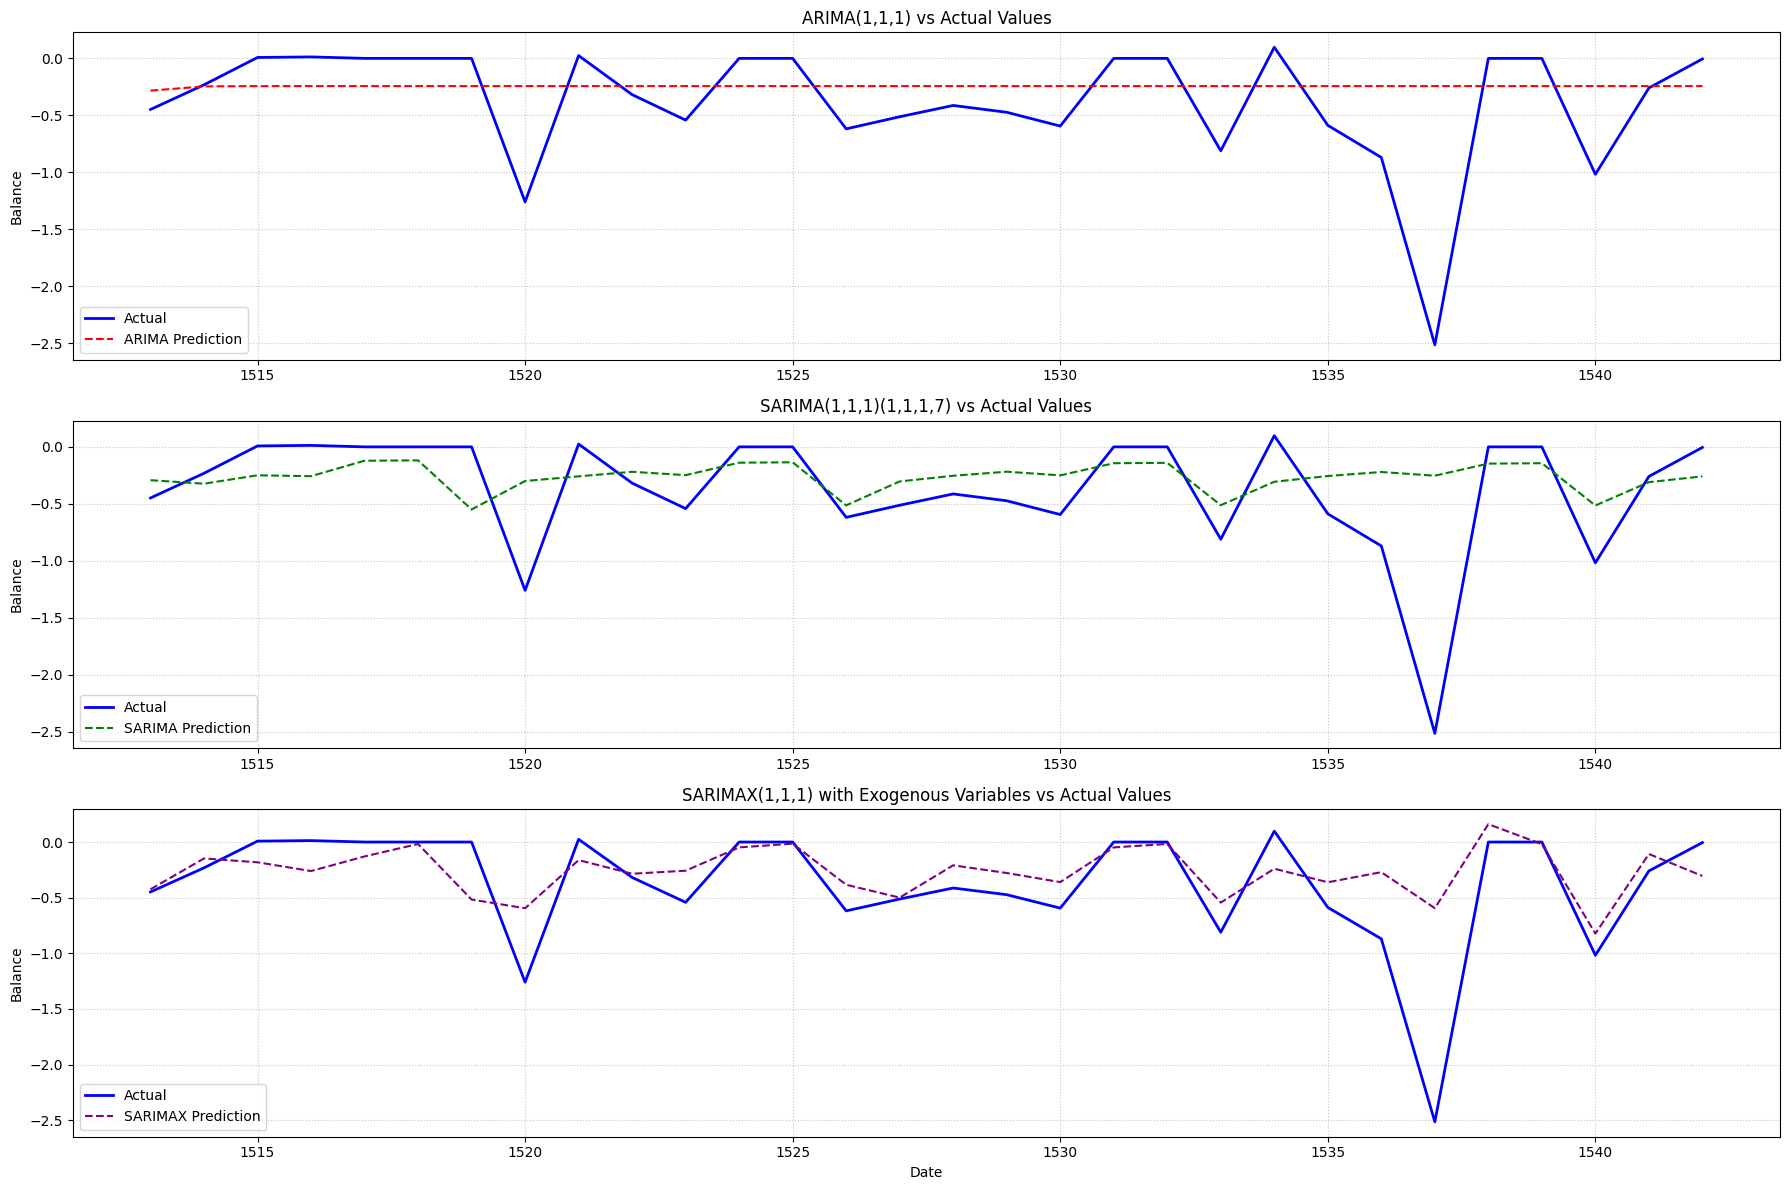

In [41]:
# Визуализация результатов - три отдельных графика
plt.figure(figsize=(18, 12))

# График 1: ARIMA vs Actual
plt.subplot(3, 1, 1)
plt.plot(y_test_series.index, y_test_series, label='Actual', color='blue', linewidth=2)
plt.plot(y_test_series.index, arima_pred, label='ARIMA Prediction', color='red', linestyle='--')
plt.title('ARIMA(1,1,1) vs Actual Values', fontsize=12)
plt.ylabel('Balance', fontsize=10)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# График 2: SARIMA vs Actual
plt.subplot(3, 1, 2)
plt.plot(y_test_series.index, y_test_series, label='Actual', color='blue', linewidth=2)
plt.plot(y_test_series.index, sarima_pred, label='SARIMA Prediction', color='green', linestyle='--')
plt.title('SARIMA(1,1,1)(1,1,1,7) vs Actual Values', fontsize=12)
plt.ylabel('Balance', fontsize=10)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

# График 3: SARIMAX vs Actual
plt.subplot(3, 1, 3)
plt.plot(y_test_series.index, y_test_series, label='Actual', color='blue', linewidth=2)
plt.plot(y_test_series.index, sarimax_pred, label='SARIMAX Prediction', color='purple', linestyle='--')
plt.title('SARIMAX(1,1,1) with Exogenous Variables vs Actual Values', fontsize=12)
plt.ylabel('Balance', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()


Видим, что SARIMA и SARIMAX дают хоть какое-то приближение, поэтому добавим их как ещё одни фичи

In [42]:
# ------ SARIMA ДОБАВИМ ------
# Для тренировочных данных
X_train.loc[:, 'sarima_feature'] = sarima_results.get_prediction(
    start=X_train.index[0], 
    end=X_train.index[-1]
).predicted_mean.values

# Для тестовых данных
X_test.loc[:, 'sarima_feature'] = sarima_pred.values

# --------- SARIMAX ДОБАВИМ --------
# Для тренировочных данных
X_train.loc[:, 'sarimax_feature'] = sarimax_results.get_prediction(
    start=X_train.index[0], 
    end=X_train.index[-1]
).predicted_mean.values

# Для тестовых данных
X_test.loc[:, 'sarimax_feature'] = sarimax_pred.values

C:\Users\Кирилл\AppData\Local\Temp\ipykernel_8172\2793521669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, 'sarima_feature'] = sarima_results.get_prediction(
C:\Users\Кирилл\AppData\Local\Temp\ipykernel_8172\2793521669.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:, 'sarimax_feature'] = sarimax_results.get_prediction(


### Обучим модель

Fitting 5 folds for each of 96 candidates, totalling 480 fits


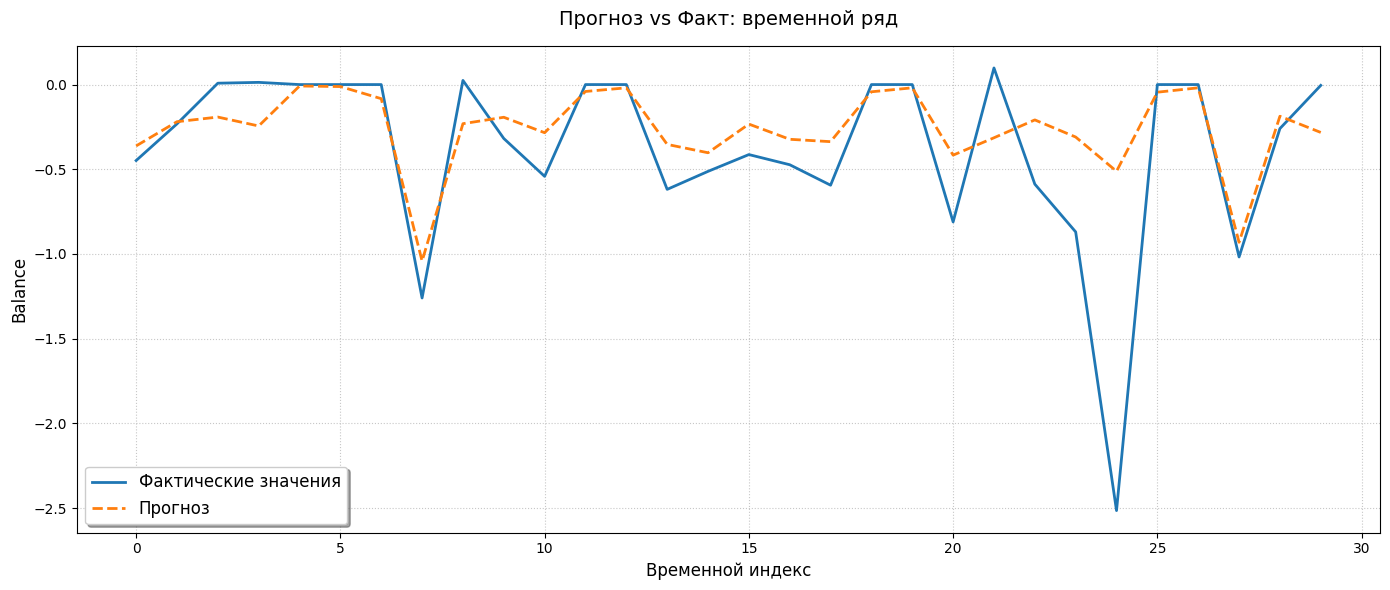

In [43]:
# 2. Настройка кросс-валидации (адаптированный подход из первой реализации)
tscv = TimeSeriesSplit(
    n_splits=5,
    gap=0,           # Промежуток между train и test
    test_size=30     # Фиксируем 30 дней для теста
)
# 3. Оптимизированный пайплайн (лучшее из обеих реализаций)
pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler()),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=52,
        n_jobs=-1,
    ))
])

# 4. Умеренный GridSearch (золотая середина)
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 4],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.8, 0.9],
    'model__reg_alpha': [0.1, 1],
    'model__reg_lambda': [0.1, 1]
}

# 5. Безопасный GridSearch только на тренировочных данных
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=tscv,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# Обучение с валидацией
grid.fit(X_train, y_train)

# Лучшая модель
best_model = grid.best_estimator_

# Прогноз и оценка
y_pred = best_model.predict(X_test)

# Визуализация (улучшенный вариант)
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Фактические значения', color='#1f77b4', linewidth=2)
plt.plot(y_pred, label='Прогноз', color='#ff7f0e', linestyle='--', linewidth=2)
plt.title('Прогноз vs Факт: временной ряд', fontsize=14, pad=15)
plt.xlabel('Временной индекс', fontsize=12)
plt.ylabel('Balance', fontsize=12)
plt.legend(fontsize=12, framealpha=1, shadow=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
# Метрики
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('=== Результаты ===')
print(f'Лучшие параметры: {grid.best_params_}')
print(f'MAE:  {mae:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'R²:   {r2:.3f}')
print(f'Использовано признаков: {len(X_train.columns)}')
print(X_train.columns)

=== Результаты ===
Лучшие параметры: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__reg_alpha': 1, 'model__reg_lambda': 1, 'model__subsample': 0.8}
MAE:  0.228
RMSE: 0.425
R²:   0.367
Использовано признаков: 10
Index(['Balance_lag_7', 'Day_of_week', 'year', 'day_of_year', 'is_outlier',
       'Balance_lag_1', 'Balance_lag_30', 'Income', 'sarima_feature',
       'sarimax_feature'],
      dtype='object')
